# Conditional Variational AutoEncoder
- 지도학습이 가능하도록 $y$를 활용함

<img src="./asset/Figure_2.png" width="400">

## 1. Import Libs

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dset
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.utils import make_grid

import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

USE_CUDA = torch.cuda.is_available()

## 2. Load Dataset

In [2]:
result_dir = './save_results/MNIST/CVAE'
model_dir = './save_models/MNIST/CVAE'

if not os.path.exists(result_dir):
    os.mkdir(result_dir)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

mnist_train = dset.MNIST('./data/MNIST', train=True, transform=transforms.ToTensor(), target_transform=None,download=True)
mnist_test = dset.MNIST('./data/MNIST', train=False, transform=transforms.ToTensor(), target_transform=None,download=True)

batch_size = 100

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

## 3. Build Model

In [3]:
class CVAE(nn.Module):
    def __init__(self, X_dim, h_dim, z_dim, y_dim):
        super(CVAE, self).__init__()
        self.X_dim = X_dim
        self.y_dim = y_dim
        
        # encode
        self.fc1 = nn.Linear(X_dim + y_dim, h_dim)
        self.fc2_1 = nn.Linear(h_dim, z_dim)
        self.fc2_2 = nn.Linear(h_dim, z_dim)
        
        # decoder
        self.fc3 = nn.Linear(z_dim + y_dim, h_dim)
        self.fc4 = nn.Linear(h_dim, X_dim)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def encode(self, x, c): # Q(z|x, c)
        """
        x : (batch_size, X_dim)
        c : (batch_size, y_dim)
        """
        inputs = torch.cat([x, c], 1) # batch_size x (X_dim + y_dim)
        out = self.relu(self.fc1(inputs))
        mu = self.fc2_1(out)
        log_var = self.fc2_2(out)
        return mu, log_var
    
    def reparameterization(self, mu, log_var):
        noise = torch.randn(mu.size())
        
        if USE_CUDA:
            noise = noise.cuda()
        
        z = mu + log_var.mul(0.5).exp() * noise    
        return z
    
    def decode(self, z, c): # P(x|z, c)
        """
        z : (batch_size, z_dim)
        c : (batch_size, y_dim)
        """
        inputs = torch.cat([z, c], 1) # batch_size x (z_dim + y_dim)
        out = self.relu(self.fc3(inputs))
        out = self.sigmoid(self.fc4(out))
        return out
    
    def forward(self, x, c):
        mu, log_var = self.encode(x.view(-1, X_dim), c)
        z = self.reparameterization(mu, log_var)
        return self.decode(z, c), mu, log_var

In [4]:
X_dim = 784
h_dim = 400
z_dim = 20
y_dim = 10 # mnist 손글자

c = torch.eye(y_dim, y_dim)
z = torch.randn(y_dim, z_dim)

model = CVAE(X_dim, h_dim, z_dim, y_dim)

if USE_CUDA:
    model = model.cuda()
    c = c.cuda()
    z = z.cuda()

## 4. Loss func & Optims

In [5]:
optimizer = optim.Adam(model.parameters(), lr=0.002)

def onehot(labels, y_dim):
    target = torch.zeros(labels.size(0), y_dim)
    for i, label in enumerate(labels):
        target[i, label] = 1
        
    if USE_CUDA:
        target = target.cuda()
    
    return target

## 5. Train

In [6]:
num_epoch = 50
total_batch = len(train_loader.dataset)//batch_size
for epoch in range(num_epoch + 1):
    for i, (image, labels) in enumerate(train_loader):
        
        if USE_CUDA:
            image = image.cuda()
            labels = labels.cuda()
            
        labels = onehot(labels, y_dim)
        X_sample, mu, log_var = model(image, labels)
        
        optimizer.zero_grad()
        
        recon_loss = nn.functional.binary_cross_entropy(X_sample, image, size_average=False) / batch_size
        kl_loss = torch.mean(0.5 * torch.sum(torch.exp(log_var) + mu**2 - 1. - log_var, 1))
        loss = recon_loss + kl_loss
        
        loss.backward()
        optimizer.step()
        
        if (i+1) % 300 == 0:
            print('Epoch [%d/%d], Step[%d/%d], recon_loss: %.4f'
              %(epoch, num_epoch, i+1, total_batch, loss.data[0]))
            
            # Save the trained parameters
            torch.save(model, model_dir + '/CVAE.pkl')
            
    # Save real images
    model.eval()
    
    sample_z = model.decode(z, c)
        
    # Save sampled images
    fake_image = sample_z.view(sample_z.size(0), 1, 28, 28)
    save_image(fake_image.data, result_dir +'/fake_images-%d.png' %(epoch+1))

/home/paulkim/anaconda3/envs/pytorch02/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([100, 1, 28, 28])) that is different to the input size (torch.Size([100, 784])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/paulkim/anaconda3/envs/pytorch02/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/paulkim/anaconda3/envs/pytorch02/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type CVAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch [0/50], Step[300/600], recon_loss: 131.3566
Epoch [0/50], Step[600/600], recon_loss: 114.1345
Epoch [1/50], Step[300/600], recon_loss: 114.0414
Epoch [1/50], Step[600/600], recon_loss: 111.8911
Epoch [2/50], Step[300/600], recon_loss: 107.0190
Epoch [2/50], Step[600/600], recon_loss: 107.9012
Epoch [3/50], Step[300/600], recon_loss: 108.0382
Epoch [3/50], Step[600/600], recon_loss: 101.3153
Epoch [4/50], Step[300/600], recon_loss: 104.6172
Epoch [4/50], Step[600/600], recon_loss: 107.0571
Epoch [5/50], Step[300/600], recon_loss: 103.6256
Epoch [5/50], Step[600/600], recon_loss: 101.3144
Epoch [6/50], Step[300/600], recon_loss: 104.9246
Epoch [6/50], Step[600/600], recon_loss: 105.9044
Epoch [7/50], Step[300/600], recon_loss: 101.0389
Epoch [7/50], Step[600/600], recon_loss: 102.1998
Epoch [8/50], Step[300/600], recon_loss: 100.3143
Epoch [8/50], Step[600/600], recon_loss: 99.9237
Epoch [9/50], Step[300/600], recon_loss: 106.4978
Epoch [9/50], Step[600/600], recon_loss: 100.7311
E

## 6. Check Train Image


 from train data image



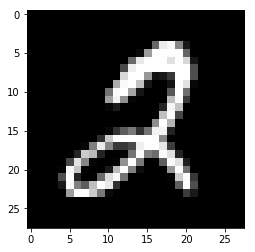


 from generated model's image



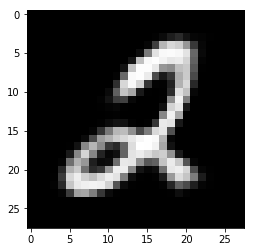


 from train data image



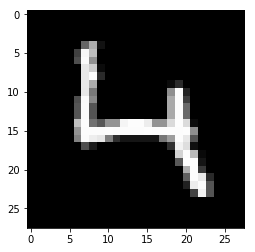


 from generated model's image



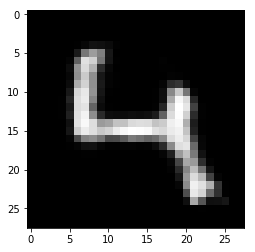


 from train data image



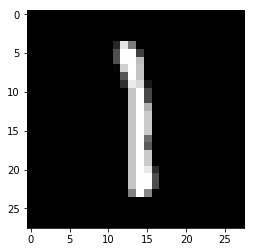


 from generated model's image



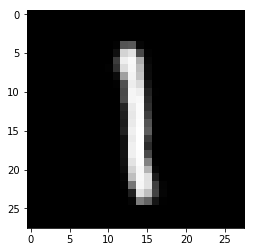


 from train data image



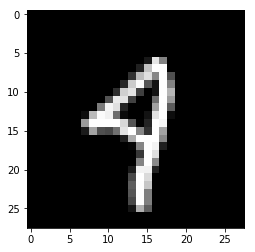


 from generated model's image



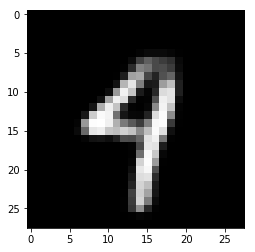


 from train data image



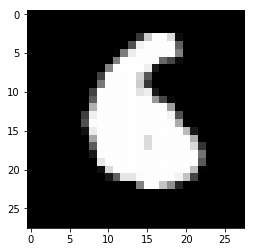


 from generated model's image



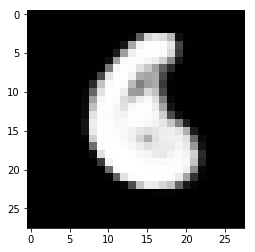

In [7]:
out_image = X_sample.view(batch_size, 28, 28).cpu().data
image = image.view(batch_size, 28, 28).cpu().data

for i in range(5):
    print("\n from train data image\n")
    plt.imshow(torch.squeeze(image[i].cpu()).data.numpy(), cmap='gray')
    plt.show()
    print("\n from generated model's image\n")
    plt.imshow(out_image[i].numpy(), cmap='gray')
    plt.show()

## 7. Display Generated Data

In [8]:
import imageio

images = []
for epoch in range(num_epoch + 1):
    try:
        img_name = result_dir +'/fake_images-%d.png' %(epoch+1)
        images.append(imageio.imread(img_name))
    except:
        pass

imageio.mimsave(result_dir + '/fake_images_total.gif', images, fps=4)

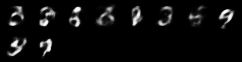

In [9]:
from IPython.display import Image

with open(result_dir + '/fake_images_total.gif','rb') as f:
    display(Image(data=f.read(), format='gif'))

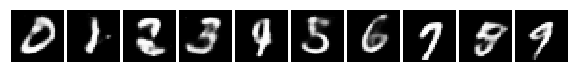

In [10]:
sample_z = model.decode(z, c).data.cpu().numpy()
    
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(10, 10)
gs.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(sample_z):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')